In [1]:
# ==========================================
# IMPORT LIBRARIES
# ==========================================

import os
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

import lightgbm as lgb

from features import extract_features

In [2]:
DATASET_PATH = "vegetable fresh rotten data"

## load data extract features

In [13]:
feature_names = [
    # RGB (6)
    "R_mean","G_mean","B_mean",
    "R_std","G_std","B_std",

    # HSV (6)
    "H_mean","S_mean","V_mean",
    "H_std","S_std","V_std",

    # LAB (6)
    "L_mean","L_std",
    "a_mean","a_std",
    "b_mean","b_std",

    # Texture (5)
    "laplacian_variance",
    "glcm_contrast","glcm_energy","glcm_homogeneity",
    "grayscale_entropy",

    # Shape (6)
    "contour_area","perimeter",
    "circularity","solidity",
    "aspect_ratio","extent",

    # Dark pixel ratio (1)
    "dark_pixel_ratio"
]

In [14]:
import pandas as pd
X = []
y = []

for label in ["Fresh", "Rotten"]:
    label_path = os.path.join(DATASET_PATH, label)

    for subfolder in os.listdir(label_path):
        subfolder_path = os.path.join(label_path, subfolder)

        for file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, file)

            features = extract_features(img_path)
            X.append(features)
            y.append(0 if label=="Fresh" else 1)

X = pd.DataFrame(X, columns=feature_names)
y = np.array(y)

print("Dataset Shape:", X.shape)

Dataset Shape: (10723, 30)


## save featurematrix

In [15]:
np.save("X_features.npy", X)
np.save("y_labels.npy", y)

## train test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [21]:
model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4269, number of negative: 4309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7640
[LightGBM] [Info] Number of data points in the train set: 8578, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497668 -> initscore=-0.009326
[LightGBM] [Info] Start training from score -0.009326


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [22]:
joblib.dump(model, "lightgbm_vegetable_freshness.pkl")
print("Model Saved Successfully")

Model Saved Successfully


In [23]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
loss = log_loss(y_test, y_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", loss)

Accuracy: 0.9146853146853147
Precision: 0.9233716475095786
Recall: 0.9034676663542643
F1 Score: 0.9133112269066793
Log Loss: 0.2156414084538331


[LightGBM] [Info] Number of positive: 4269, number of negative: 4309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7640
[LightGBM] [Info] Number of data points in the train set: 8578, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497668 -> initscore=-0.009326
[LightGBM] [Info] Start training from score -0.009326
[LightGBM] [Info] Number of positive: 4269, number of negative: 4309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7640
[LightGBM] [Info] Number of data points in the train set: 8578, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497668 -> initscore=-0.009326
[LightGBM] [Info] Start training from score -0.009326
[LightGBM] [Info] 

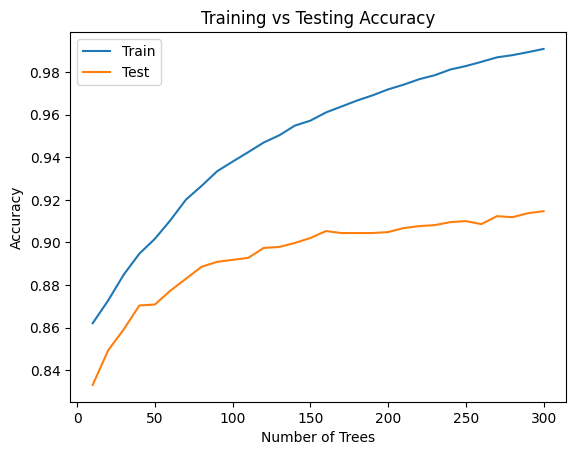

In [24]:
train_acc = []
test_acc = []

for i in range(10, 310, 10):
    temp_model = lgb.LGBMClassifier(n_estimators=i, learning_rate=0.05)
    temp_model.fit(X_train, y_train)

    train_acc.append(accuracy_score(y_train, temp_model.predict(X_train)))
    test_acc.append(accuracy_score(y_test, temp_model.predict(X_test)))

plt.plot(range(10,310,10), train_acc)
plt.plot(range(10,310,10), test_acc)
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.legend(["Train","Test"])
plt.title("Training vs Testing Accuracy")
plt.show()

In [25]:
# ==========================================
# COMPLETE MODEL EVALUATION
# ==========================================

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    confusion_matrix,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# Basic classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
loss = log_loss(y_test, y_prob)

# Regression-style metrics (using probability of class 1)
y_prob_positive = y_prob[:, 1]

rmse = np.sqrt(mean_squared_error(y_test, y_prob_positive))
mae = mean_absolute_error(y_test, y_prob_positive)
r2 = r2_score(y_test, y_prob_positive)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Print everything
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", loss)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

print("\nConfusion Matrix:")
print(cm)

print("\nTrue Negatives (Fresh predicted Fresh):", tn)
print("False Positives (Fresh predicted Rotten):", fp)
print("False Negatives (Rotten predicted Fresh):", fn)
print("True Positives (Rotten predicted Rotten):", tp)

Accuracy: 0.9146853146853147
Precision: 0.9233716475095786
Recall: 0.9034676663542643
F1 Score: 0.9133112269066793
Log Loss: 0.2156414084538331
RMSE: 0.25490362742399064
MAE: 0.13916403107021366
R²: 0.7400897276572296

Confusion Matrix:
[[998  80]
 [103 964]]

True Negatives (Fresh predicted Fresh): 998
False Positives (Fresh predicted Rotten): 80
False Negatives (Rotten predicted Fresh): 103
True Positives (Rotten predicted Rotten): 964
